# Modelo de clasificación de imágenes usando un MLP

In [ ]:
!pip install torch
!pip install datasets
!pip install numpy
!pip install matplotlib
!pip install scikit-learn

In [ ]:
import torch.utils.data
import datasets
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [ ]:
# Multi Layer Perceptron
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        self.hidden_layers = nn.ModuleList()
        previous_dim = input_dim

        for hidden_dim in hidden_dims:
            self.hidden_layers.append(nn.Linear(previous_dim, hidden_dim))
            previous_dim = hidden_dim

        self.output_layer = nn.Linear(previous_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, input: torch.Tensor):
        batch_size = input.shape[0]
        x = input.view(batch_size, -1)

        for layer in self.hidden_layers:
            x = self.relu(layer(x))

        x = self.output_layer(x)
        return x

In [ ]:
# Auxiliary functions
def fit_model(
    model: nn.Module,
    train_loader: DataLoader,
    epochs: int,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device
):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")
    return model

def predict(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
):
    model.eval()
    probs_predicted = []
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            output_probs: torch.Tensor = model(images)
            probs_predicted += output_probs.tolist()
    return probs_predicted

In [ ]:
# This class helps to transform data to pytorch-compatible format
class TransformedImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset: datasets.Dataset):
        self.dataset = dataset
        self.transforms = transforms.Compose([
                transforms.Resize((30, 30)),
                transforms.ToTensor(),
            ])

        column_names = list(self.dataset.features.keys())
        self.image_col_name = column_names[0]
        self.tensor_shape = self.transforms(self.dataset[0][self.image_col_name]).shape
        self.input_dim = (self.tensor_shape[0] *
                          self.tensor_shape[1] *
                          self.tensor_shape[2])
        if len(column_names) > 1:
            self.label_col_name = column_names[1]
            self.output_dim = len(set(self.dataset[self.label_col_name]))
        else:
            self.label_col_name = None

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx][self.image_col_name]
        image = self.transforms(image)
        if self.label_col_name is None:
            return image
        label = self.dataset[idx][self.label_col_name]
        return image, label

In [ ]:
# MLP Image Classifier class
# This class already fulfill the DashAI model's interface (methods and signatures)

class MLPImageClassifier():

    def __init__(self, epochs, learning_rate, hidden_dims, **kwargs):
        super().__init__(**kwargs)
        self.epochs = epochs
        self.hidden_dims = hidden_dims
        self.learning_rate = learning_rate
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None

    def fit(self, x_train: datasets.Dataset, y_train: datasets.Dataset):
        # Adapt adn transform x_train and y_train datasets to Pytorch Dataset
        dataset = datasets.Dataset.from_dict(
            {
                "image": x_train["image"],
                "label": y_train["label"],
            }
        )
        image_dataset = TransformedImageDataset(dataset)
        train_loader = DataLoader(image_dataset, batch_size=32, shuffle=True)

        # Set model
        self.model = MLP(
            image_dataset.input_dim,
            image_dataset.output_dim,
            self.hidden_dims
        ).to(self.device)
        self.criteria = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.model = fit_model(
            self.model,
            train_loader,
            self.epochs,
            self.criteria,
            self.optimizer,
            self.device,
        )

    def predict(self, x_pred: datasets.Dataset):
        image_dataset = TransformedImageDataset(x_pred)
        test_loader = DataLoader(image_dataset, batch_size=32, shuffle=False)
        predicted = predict(self.model, test_loader, self.device)
        return predicted

    def predict_one_image(self, image):
        self.model.eval()
        image = image.to(self.device)
        output = self.model(image)
        _, predicted = torch.max(output, 1)
        return predicted

    def save(self, filename: str) -> None:
        """Save the model in the specified path."""
        torch.save(self.model, filename)

    @staticmethod
    def load(filename: str) -> None:
        """Load the model of the specified path."""
        model = torch.load(filename)
        return model

# Entrenando el modelo con MNIST Dataset (reducido)

In [ ]:
!unzip 'Reduced MNIST Data.zip'

Archive:  Reduced MNIST Data.zip
replace __MACOSX/._Reduced MNIST Data? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Load Dataset
dataset_dict = datasets.load_dataset("imagefolder", data_dir="Reduced MNIST Data")
mnist_dataset: datasets.Dataset = dataset_dict["train"]

# Split the dataset into train and validation
train_test_split = mnist_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

Resolving data files:   0%|          | 0/12000 [00:00<?, ?it/s]

In [ ]:
# Parameters
epochs = 3
hidden_dims = [128,128,128]
learning_rate = 0.001

# Divide partitions into input and output Datasets
x_train = datasets.Dataset.from_dict({"image": train_dataset["image"]})
y_train = datasets.Dataset.from_dict({"label": train_dataset["label"]})
x_test = datasets.Dataset.from_dict({"image": test_dataset["image"]})
y_test = datasets.Dataset.from_dict({"label": test_dataset["label"]})

# Set model
mlp_image_classifier = MLPImageClassifier(epochs, learning_rate, hidden_dims)
# Fit model
mlp_image_classifier.fit(x_train,y_train)
# Predict test data
predictions = mlp_image_classifier.predict(x_test)

Epoch 1/3, Loss: 0.4890737235546112
Epoch 2/3, Loss: 0.09794078022241592
Epoch 3/3, Loss: 0.2821083068847656


In [ ]:
# Accuracy
from sklearn.metrics import accuracy_score
import numpy as np

pred_labels = np.argmax(predictions, axis=1)

accuracy_score(y_test['label'], pred_labels)

0.9291666666666667

In [ ]:
# Predict one image
test_image_dataset = TransformedImageDataset(test_dataset)
image, label = test_image_dataset[32]
predicted = mlp_image_classifier.predict_one_image(image.unsqueeze(0))
print(f"Predicted: {predicted.item()}, Actual: {label}")

Predicted: 0, Actual: 0


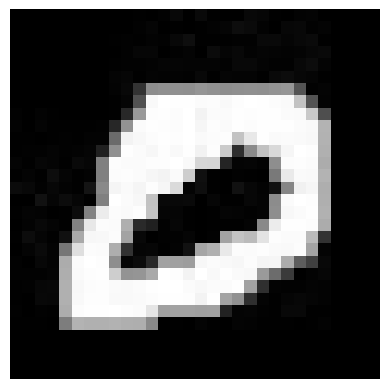

In [ ]:
import torch
import matplotlib.pyplot as plt

# Convertir el tensor a un array de Numpy
image = image.squeeze()
image_array = image.numpy()

# Asegurarse de que los valores estén en el rango correcto (0 a 255)
image_array = (image_array * 255).astype('uint8')

# Mostrar la imagen usando Matplotlib
plt.imshow(image_array, cmap='gray')
plt.axis('off')  # Ocultar los ejes
plt.show()